<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [40]:
from scipy import stats
import numpy as np
from binarytree import Node, show
from sklearn.base import BaseEstimator
from collections import Counter

def entropy(y):
    freq = stats.itemfreq(y)[:, 1]
    freq = freq/len(y)
    return -np.sum(freq*np.log2(freq))


def gini(y):
    freq = stats.itemfreq(y)[:, 1]
    freq = freq/len(y)
    return 1 - np.sum(freq**2)


def variance(y):
    return np.mean((y - np.mean(y))**2)


def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))

In [45]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf, min_samples_split=2,
                 criterion=None, tree_type='classification', debug=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.debug = debug
        self.root = Node((None, None, None))
        self.tree_type = tree_type
        if tree_type == 'classification' and criterion is None:
            criterion = 'gini'
        elif tree_type == 'regression' and criterion is None:
            criterion = 'variance'
        if criterion is 'gini':
            self.criterion_func = gini
        elif criterion is 'entropy':
            self.criterion_func = entropy
        elif criterion is 'variance':
            self.criterion_func = variance
        elif criterion is 'mad_median':
            self.criterion_func = mad_median

    def fit(self, X, y):
        self._fit(X, y, self.root)
        return self

    def _fit(self, X, y, node):
        if self.min_samples_split >= len(y) or self.criterion_func(y) == 0:
            node.value = (node.value[0], node.value[1], self._get_result(y))
            return
        criterion = self.criterion_func(y)
        Qs = []
        for feature_index in range(X.shape[1]):
            x = X[:, feature_index]
            bounds = DecisionTree._get_bounds(x, y)
            for bound in bounds:
                Qs.append(self._get_Q(criterion, x, y, feature_index, bound))
        Q_max = max(Qs, key=lambda item: item['score'])
        indices_left = X[:, Q_max['feature_index']] <= Q_max['bound']
        indices_right = X[:, Q_max['feature_index']] > Q_max['bound']
        node.value = (Q_max['feature_index'], Q_max['bound'], None)
        node.left = Node((None, None, None))
        node.right = Node((None, None, None))
        self._fit(X[indices_left, :], y[indices_left], node.left)
        self._fit(X[indices_right, :], y[indices_right], node.right)

    def _get_Q(self, criterion, x, y, feature_index, bound):
        indices_left = x <= bound
        indices_right = x > bound
        score = criterion - self.criterion_func(y[indices_left]) - self.criterion_func(y[indices_right])
        return {
            'score': score,
            'feature_index': feature_index,
            'bound': bound
        }

    def _get_result(self, y):
        if self.tree_type == 'regression':
            return np.mean(y)
        elif self.tree_type == 'classification':
            c = Counter(y)
            return c.most_common(1)[0][0]

    def predict(self, X):
        result = []
        for row in X:
            node = self.root
            while node.value[2] is None:
                if row[node.value[0]] <= node.value[1]:
                    node = node.left
                else:
                    node = node.right
            result.append(node.value[2])
        return np.array(result)

    def predict_proba(self, X):
        return self.predict(X)

    @staticmethod
    def _get_bounds(x, y):
        data = np.zeros((len(x), 2))
        data[:, 0] = x
        data[:, 1] = y
        data = data[data[:, 0].argsort()]
        bounds = set()
        current_item = data[0, 1]
        for index in range(data.shape[0]):
            if current_item != data[index][1]:
                bound = (data[index][0] + data[index - 1][0])/2
                current_item = data[index][1]
                bounds.add(bound)
        return np.array(list(bounds))

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [46]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [47]:
dataset = load_digits()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=17)

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [ ]:
tree = DecisionTree()
tree.fit(X_train, y_train)

In [43]:
accuracy_score(tree.predict(X_train), y_train)

0.99652052887961029

In [38]:
y_train[:2]

array([1, 9])

In [40]:
from sklearn.tree import DecisionTreeClassifier
tree_c = DecisionTreeClassifier()
tree_c.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [42]:
accuracy_score(tree_c.predict(X_train), y_train)

1.0

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [9]:
from sklearn.tree import DecisionTreeClassifier
params = {
    'max_depth': range(3, 11),
    'criterion': ['gini', 'entropy'],
    
}
tree = DecisionTreeClassifier()
grid_cv = GridSearchCV(tree, params, cv=5, scoring='accuracy')
grid_cv.fit(X_train, y_train)
grid_cv.cv_results_

{'mean_fit_time': array([ 0.00411911,  0.00520477,  0.00600557,  0.00700917,  0.00790739,
         0.0087069 ,  0.00930557,  0.00950737,  0.00500736,  0.00680437,
         0.00890861,  0.01060815,  0.01221147,  0.0131135 ,  0.01331282,
         0.01331263]),
 'mean_score_time': array([  4.03928757e-04,   2.00366974e-04,   2.00128555e-04,
          3.00455093e-04,   2.00223923e-04,   9.99927521e-05,
          2.00271606e-04,   3.00168991e-04,   9.98973846e-05,
          2.00319290e-04,   1.00088120e-04,   4.02688980e-04,
          2.00271606e-04,   1.00183487e-04,   3.00168991e-04,
          9.99450684e-05]),
 'mean_test_score': array([ 0.48086291,  0.56924148,  0.67292971,  0.76130828,  0.81002088,
         0.83924843,  0.84759916,  0.85038274,  0.53235908,  0.6750174 ,
         0.76548365,  0.82602644,  0.85038274,  0.86917189,  0.86430063,
         0.8670842 ]),
 'mean_train_score': array([ 0.48870313,  0.59239532,  0.70077594,  0.81699509,  0.90032478,
         0.93895097,  0.966259

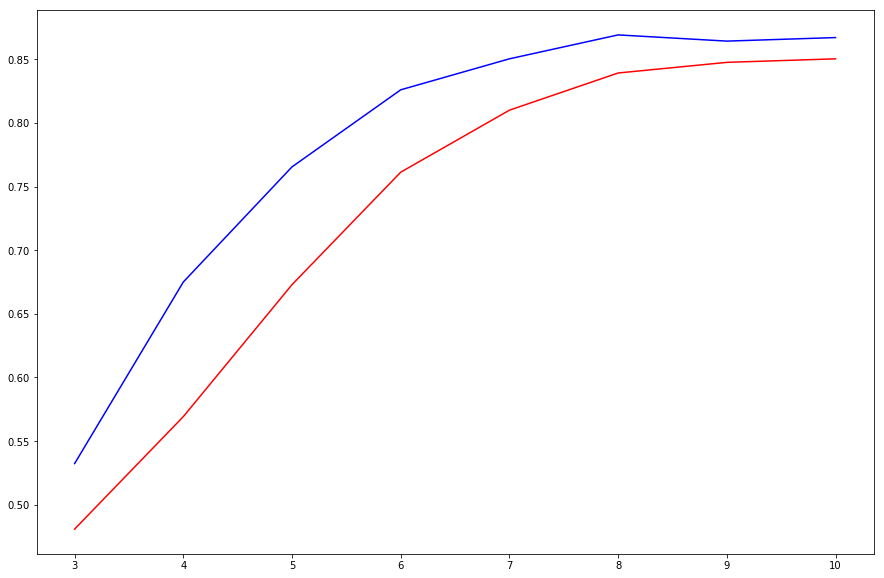

In [17]:
plt.figure(figsize=(15, 10))
plt.plot([item['max_depth'] for item in grid_cv.cv_results_['params'][:8]], grid_cv.cv_results_['mean_test_score'][:8], 'r')
plt.plot([item['max_depth'] for item in grid_cv.cv_results_['params'][8:]], grid_cv.cv_results_['mean_test_score'][8:], 'b')

**Выберите верные утверждения:**
1. Оптимальное значение max_depth для каждого критерия достигается внутри отрезка [3, 10] (то есть на отрезке [4, 9]).
2. **На отрезке [3, 10] построенные графики не пересекаются.**
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при max_depth на интервале [3, 10] достигается на критерии gini.
5. **Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].**

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 4, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. **max_depth = 10, criterion = 'gini';**
5. max_depth = 3, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [36]:
np.mean(grid_cv.best_estimator_.predict_proba(X_test), axis=0)

array([ 0.08888889,  0.08533615,  0.10021605,  0.09763419,  0.12412698,
        0.10787037,  0.07777778,  0.09027778,  0.11215062,  0.11572119])

In [22]:
X_test.shape

(360, 64)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему равна максимальная вероятность в полученном векторе?
1. 0.11218791
2. 0.11783761
3. 1.0
4. 0.0875

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [ ]:
# Ваш код здесь

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [ ]:
# Ваш код здесь

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [ ]:
# Ваш код здесь

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth in range(2, 9) достигается на критерии variance.
5. График качества ровно для одного из критериев имеет явно выраженный пик.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 8, criterion = 'variance';